<a href="https://colab.research.google.com/github/YomarPeralta/Jupyter-Lab/blob/main/ZambranoA_RazaD_PeraltaY_NotebookBase_Programaci%C3%B3nDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Mineria de Datos</header1></center>

Presentado por: Anderson Zambrano, Dyllan Raza y Yomar Peralta - Grupo  5<br>
Lider: Dyllan Raza  <br>
Fecha: 16/08/2022

# Importación de librerias necesarias

In [ ]:
#Para esta actividad se importarán las siguientes librerías:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud

## Cargar el Dataset

In [ ]:
#Código para cargar el Dataset
odf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Reviews.csv')
#Ahora cargamos el conjunto de datos y agregamos algunas columnas para las métricas de votos a favor:
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


## Descripción de la fuente del Dataset

En este conjunto de datos reposan historiales de alimentos finos de Amazon. Los datos abarcan un período de más de 10 años, incluidos los aproximadamente 568 mil historiales hasta octubre de 2012. Los historiales incluyen información del producto y del usuario, calificaciones y una pequeña acotacion de texto sin formato. También incluye histriales de todas las demás categorías de Amazon.

## Explique el problema a resolver. 
Lo que se pretende solucionar con este modelo es que se pueda mejorar la interaccion que los usuarios tienen con la plataforma, tomando en cuenta que sea cual sea el tipo de compra que este realice debe ejecutarse de manera satisfacctoria

In [ ]:
#Código que responde a la descripción anterior
odf.shape

(568454, 12)

## Caracterización del Dataset

Realice una descripción de los datos con:

Los datos incluyen:

>- Reseñas de octubre de 1999 a octubre de 2012
>- 568,454 reseñas
>- 256.059 usuarios
>- 74,258 productos
>- 260 usuarios con > 50 reseñas


## Preprocesamiento del dataset. Transformaciones previas necesarias para la modelación

Text(0.5, 1.0, 'How helpful users find among user scores')

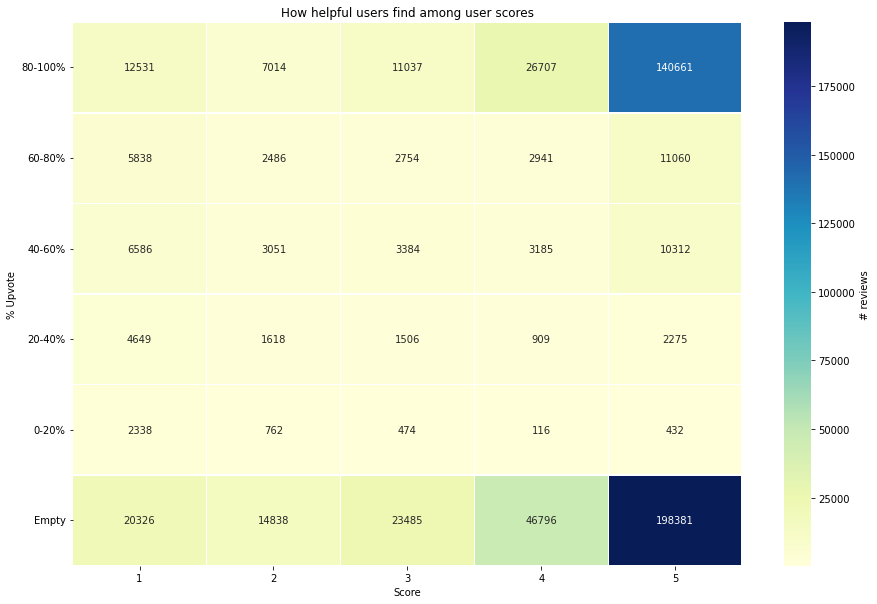

In [ ]:
#Transformación de las caracteristicas (mire el apartado Feature engineering del aula virtual)
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

Las críticas están sesgadas hacia lo positivo.

Más de la mitad de las reseñas son con cero votos

Mucha gente está de acuerdo con la puntuación 5 reseñas

Luego nos deshacemos de las reseñas de puntuación 3 (neutrales) y separamos las reseñas restantes en clases binarias (1 = positivo, 0 = negativo):

In [ ]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

'''Predicción de puntuación
Modelo de regresión logística sobre recuento de palabras'''

In [ ]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Model Accuracy: 0.9358102454090405

-Top 20 positive-
       Word  Coefficient
 pleasantly     4.232730
   downside     3.125648
  addicting     2.958208
   drawback     2.669476
  skeptical     2.510482
     resist     2.379250
 economical     2.265155
       whim     2.235738
   soothing     2.218361
    easiest     2.206106
     hooked     2.173942
    welcome     2.083908
  delighted     2.078764
      meets     1.976063
        yay     1.975571
  excellent     1.970803
wonderfully     1.970568
    worries     1.944912
exceptional     1.941874
     delish     1.933417

-Top 20 negative-
         Word  Coefficient
        ruins    -2.305289
       lacked    -2.326984
        blech    -2.333991
   unfinished    -2.349367
   unbearable    -2.355606
          ick    -2.418676
   overpowers    -2.488406
  unappealing    -2.531167
  disapointed    -2.557415
      defeats    -2.613754
   returnable    -2.683771
     mediocre    -2.735403
       ripoff    -2.843023
disappointing    -2.9458

La accuraccy es de alrededor del 93,5%, no está mal. Sin embargo, notamos que algunos de esos coeficientes significativos no son significativos, p. 280 mg.

Veamos también la precisión de la línea base (prediciendo con clase mayoritaria, en este caso clase positiva):

In [ ]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.8437324082949168


Logistic regression model on TFIDF¶

In [ ]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Model Accuracy: 0.9346083040455216

-Top 20 positive-
      Word  Coefficient
     great    13.695298
 delicious    12.264886
      best    11.967094
   perfect    10.723732
 excellent    10.013792
     loves     9.552907
    highly     8.970362
      love     8.286137
 wonderful     8.087789
   amazing     7.729151
   awesome     7.501135
pleasantly     7.455942
      good     7.348545
      nice     7.096568
    hooked     7.076224
   pleased     6.980317
    smooth     6.910817
  favorite     6.853610
     yummy     6.821671
 fantastic     6.569467

-Top 20 negative-
          Word  Coefficient
         waste    -5.647138
          poor    -5.756170
   undrinkable    -5.866625
          yuck    -5.945607
         stale    -6.088770
         worse    -6.217101
         bland    -6.345562
          weak    -6.477051
    disgusting    -6.514147
         threw    -6.727794
     tasteless    -6.733551
        return    -6.795280
 unfortunately    -7.411392
      horrible    -7.850534
dis

El accuraccy es aproximadamente la misma: 93,4 %. Sin embargo, notamos que las palabras significativas tienen mucho más sentido ahora

Logistic regression model on TFIDF + ngram

In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Model Accuracy: 0.9456768147032422

-Top 20 positive-
     Word  Coefficient
    great    20.656004
     best    17.912018
delicious    16.972224
  perfect    14.507385
    loves    13.706369
     love    13.044294
excellent    13.036191
     good    11.403729
wonderful    11.200842
     nice    10.901578
 favorite    10.659798
  amazing     9.561725
  awesome     9.251510
     easy     9.141534
    happy     8.964936
  pleased     8.778300
   smooth     8.607139
    yummy     8.502293
    tasty     8.459028
   highly     8.402930

-Top 20 negative-
          Word  Coefficient
         maybe    -7.892097
        hoping    -8.053516
         money    -8.167249
     tasteless    -8.196235
         worse    -8.266857
       thought    -8.448484
    disgusting    -8.679442
         bland    -9.116741
         threw    -9.248305
         stale    -9.972202
        return   -10.099827
          weak   -10.110367
disappointment   -10.274333
 unfortunately   -10.802058
      horrible   -11.287

Al agregar el parámetro ngram, podemos entender frases como "no es bueno". Por lo tanto, la precisión sube un poco al 94,5%. Podemos ver que "muy recomendable" está en el puesto 20 de palabras positivas


In [ ]:
df = df[df['Score'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
1.0    151721
0.0      2707
Name: % Upvote, dtype: int64


In [ ]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.loc[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5414


In [ ]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 15844
# train records: 4060
# test records: 1354
Model Accuracy: 0.7104874446085672

-Top 20 positive-
      Word  Coefficient
       com     1.534636
    longer     1.269332
     weird     1.258520
california     1.244574
     saver     1.197867
     value     1.165717
  quantity     1.159178
  dressing     1.141080
    keurig     1.123951
    stevia     1.118603
      teas     1.115924
  popchips     1.086641
 favorites     1.079693
  training     1.055784
   cheaper     1.052992
   sitting     1.036024
  flavored     1.030345
     packs     1.029196
  fabulous     1.025442
      paid     1.015899

-Top 20 negative-
      Word  Coefficient
     gonna    -1.018275
    skinny    -1.020589
 overpower    -1.023109
      zico    -1.023209
    matter    -1.039278
   markets    -1.041676
  brooklyn    -1.056667
    middle    -1.061338
     cause    -1.061425
   cleanse    -1.062812
   freshly    -1.083384
    seller    -1.093535
   instant    -1.106657
    newman    -1.123844
  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 142728
# train records: 4060
# test records: 1354
Model Accuracy: 0.7230428360413589


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



-Top 20 positive-
     Word  Coefficient
     food     2.198744
   flavor     1.652919
       ve     1.527509
wonderful     1.261276
     teas     1.218320
     make     1.132877
      bag     1.123785
   longer     1.110112
     rice     1.088898
    seeds     1.086809
      mix     1.077010
     just     1.051198
      tea     1.041402
    loves     1.004898
    sugar     0.976165
  started     0.959109
      lot     0.957474
     chai     0.939667
      box     0.938246
     bags     0.936550

-Top 20 negative-
         Word  Coefficient
      package    -0.872894
   refreshing    -0.908349
       lipton    -0.915122
       bottle    -0.924467
product great    -0.929136
          new    -0.949494
       thanks    -0.972434
     received    -1.009538
         item    -1.035750
       marley    -1.062443
         know    -1.093886
        order    -1.096022
      service    -1.110123
         zico    -1.124651
       seller    -1.125465
   cappuccino    -1.140970
       coffee    -1.

In [ ]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['Text'].iloc[:100:20])

Downvote score 5 comments examples:
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object
Upvote score 5 comments examples
71742     This product is a delicious strong coffee blen...
377133    For some inexplicable reason, Frito Lay stoppe...
184791    I can no longer find this item locally so am d...
371727    All of the Ortiz tuna I've tried has been wond...
509935    Excellent!  Very happy with the product.  I am...
Name: Text, dtype: object


In [ ]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']

% Upvote                  0          1
word_count        83.927226  87.710011
capital_count     19.252678  14.208349
question_mark      0.180273   0.073144
exclamation_mark   0.906169   0.937200
punctuation       22.482822  19.374954


## División del dataset en datos de entrenamiento y datos de test 

In [ ]:
#Código que realice la división en entrenamiento y test, de acuerdo con la estretgia de evaluación planeada. Describa cuál es.
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)



## Modelamiento

In [ ]:
#Códo del modelo

clf_svm = svm.SVC(kernel="linear").fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)


## Evaluación del Modelo

In [ ]:
#Test
print('SVM accuracy: {}'.format(acc_svm))

SVM accuracy: 0.5745937961595273


In [ ]:
df_user = odf.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


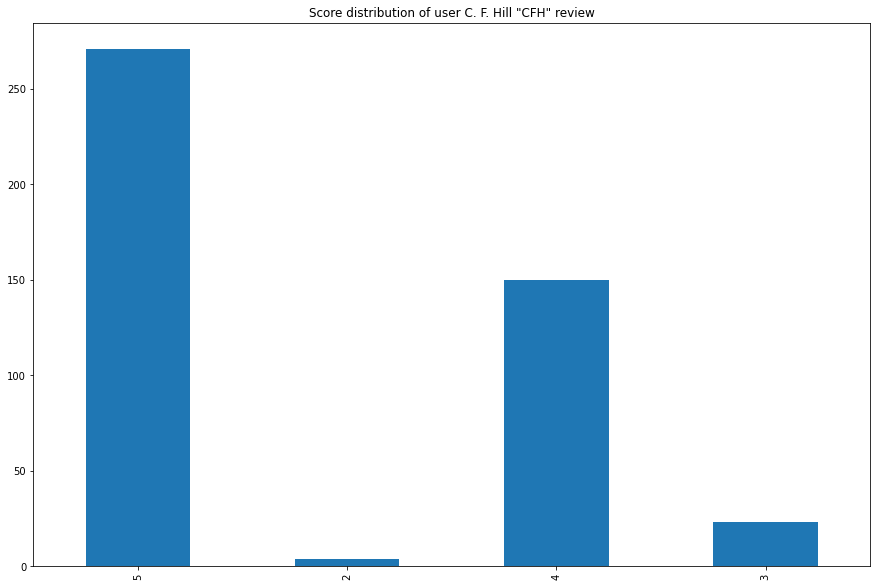

In [ ]:
def plot_user(UserId):
    df_1user = odf[odf['UserId'] == UserId]['Score']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Score distribution of user {} review'.format(odf[odf['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A3OXHLG6DIBRW8')

In [ ]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())


                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


# Interpretación de Resultados

el modelo utilizado fue SVM, lamentablemente el dataset fue sobre comentarios y no sobre algun otro tipo de clasificación. Por lo tanto se aplicó análisis de sentimientos y sobre estos resultados se trató de aplicar SVM. Se obtuvo un accuraccy de 57%, lo cual muestra que incluso habiendo un procesamiento de datos este modelo no se acopla al problema ó se necesitan procesos más complejos antes de aplicar algún tipo de modelo